# User log clustering for the v2 dataset

In [1]:
import itertools
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tslearn import clustering
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

from churn.etl import psql_tools

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/home/mariosk/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load and inspect the transaction data

In [2]:
%%time
transaction_manager = psql_tools.TransactionManager()
user_logs = (
    transaction_manager.pd_read_psql('select * from user_logs_v2')
    .assign(date=lambda df: pd.to_datetime(df['date'], format='%Y%m%d')))
user_logs.shape

CPU times: user 18.1 s, sys: 3.45 s, total: 21.6 s
Wall time: 38.4 s


(18396362, 9)

## Pre-process the data and split into weekly chunks

In [3]:
%%time
min_sequence_length = 14

logs_per_user = list(tqdm(
    map(
        lambda pair: pair[1].sort_values('date'),
        filter(
            lambda pair: len(pair[1]) >= min_sequence_length,
            user_logs.groupby('msno'))),
))

655809it [04:25, 2473.56it/s]

CPU times: user 4min 25s, sys: 4.35 s, total: 4min 30s
Wall time: 4min 25s


In [4]:
def get_weekly_intervals(user_logs_df):
    full_idx = pd.date_range(min(user_logs_df['date']), max(user_logs_df['date']), freq='D')
    df_with_full_indices = (
        user_logs_df
        .set_index('date')
        .reindex(full_idx, fill_value=0)
        .reset_index()
        .rename(columns=dict(index='date')))
    
    return [
        week_df
        for _, week_df in df_with_full_indices.groupby(pd.Grouper(key='date', freq='W-SUN'))
        if len(week_df) == 7]

In [11]:
%%time
weekly_ts = []
weeks_per_msno = []
for log in tqdm(logs_per_user):
    intervals = get_weekly_intervals(log)
    for interval in intervals:
        weekly_ts.append(interval.drop(columns=['msno', 'date']))
    weeks_per_msno.append((log.iloc[0]['msno'], len(intervals)))

weeks_per_msno = pd.DataFrame(weeks_per_msno, columns=['msno', 'n_weeks'])

weekly_ts = np.stack(weekly_ts, axis=0).astype(np.float32)
weekly_ts = (weekly_ts - weekly_ts.min(axis=0).min(axis=0)) / (weekly_ts.max(axis=0).max(axis=0) - weekly_ts.min(axis=0).min(axis=0))
weekly_ts.shape

In [12]:
np.save('/home/mariosk/data/kkbox-churn/proc_weekly_ts.npz', weekly_ts)

In [29]:
weeks_per_msno.to_csv('/home/mariosk/data/kkbox-churn/weeks_per_msno.csv', index=False)

## Split into train and validation
**Note:** This split is different from the one in the chunk prediction, thus some data leackage could occur between the datasets (hopefully not very large, given this is an unsupervised model).

In [30]:
x_train, x_valid = train_test_split(weekly_ts, random_state=94642)

In [33]:
# np.save('/home/mariosk/data/kkbox-churn/proc_x_train_ae.npz', x_train)
# np.save('/home/mariosk/data/kkbox-churn/proc_x_valid_ae.npz', x_valid)

# x_train = np.load('/home/mariosk/data/kkbox-churn/proc_x_train_ae.npy')
# x_valid = np.load('/home/mariosk/data/kkbox-churn/proc_x_valid_ae.npy')

In [34]:
batch_size = 128

train_ds = (
    tf.data.Dataset.from_tensor_slices(x_train)
    .map(lambda x: (x, x))
    .shuffle(len(x_train))
    .batch(batch_size))

valid_ds = (
    tf.data.Dataset.from_tensor_slices(x_valid)
    .map(lambda x: (x, x))
    .batch(batch_size))

Cause: could not parse the source code:

    .map(lambda x: (x, x))

This error may be avoided by creating the lambda in a standalone statement.

Cause: could not parse the source code:

    .map(lambda x: (x, x))

This error may be avoided by creating the lambda in a standalone statement.

Cause: could not parse the source code:

    .map(lambda x: (x, x))

This error may be avoided by creating the lambda in a standalone statement.

Cause: could not parse the source code:

    .map(lambda x: (x, x))

This error may be avoided by creating the lambda in a standalone statement.



## Visualize time series
The trandition time series plots are not that great for multiple features. Images seem to be more intuitive.

In [35]:
def plot_time_series_with_centroid(ts_samples, centroid=None, ax=None, alpha=0.1):
    if ax is None:
        ax = plt.gca()
        
    ax.set_axis_off()
    for sample in ts_samples:
        ax.plot(sample, color='steelblue', linewidth=0.5, alpha=alpha)
    
    if centroid is not None:
        ax.plot(centroid, color='indianred', linewidth=1)

In [36]:
def plot_time_series_all_features(ts_samples, centroids, alpha=0.1, figsize=(10, 1)):
    _, axes = plt.subplots(1, 7, figsize=figsize)
    for ax, ts, centroid in zip(axes, np.transpose(ts_samples, (2, 0, 1)), np.transpose(centroids, (1, 0))):
        plot_time_series_with_centroid(ts, centroid, ax, alpha=alpha)
        
    plt.show()

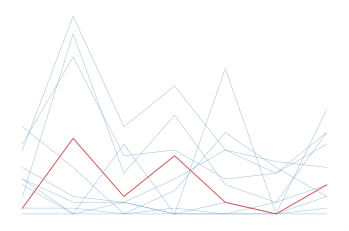

In [37]:
plot_time_series_with_centroid(x_train[:10, :, 0], x_train[11, :, 0], alpha=0.5)

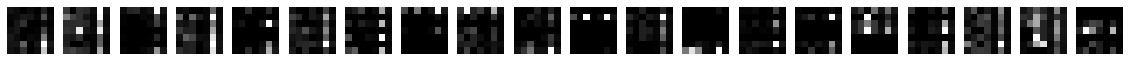

In [38]:
n_ts = 20
_, ax = plt.subplots(1, n_ts, figsize=(20, 4))
for i, s in enumerate(x_train[:n_ts]):
    ax[i].imshow(s, cmap='gray')
    ax[i].set_axis_off()
plt.show()

## Clustering with dynamic time warping
Simple method, but unfortunately too slow and not very adaptive. 

In [20]:
dtw_kmeans = clustering.TimeSeriesKMeans(
    n_clusters=15, 
    metric='dtw',
    max_iter=10,
    n_jobs=-1,
    verbose=False)

In [21]:
%%time
sample_idx = np.random.choice(len(x_train), 2000)
x_train_sample = x_train[sample_idx]
dtw_kmeans.fit(x_train_sample)

CPU times: user 41.8 s, sys: 7.79 s, total: 49.6 s
Wall time: 41.2 s


TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=15, n_jobs=-1,
                 verbose=False)

In [22]:
%time
train_clusters =  dtw_kmeans.predict(x_train_sample)

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 37.2 µs


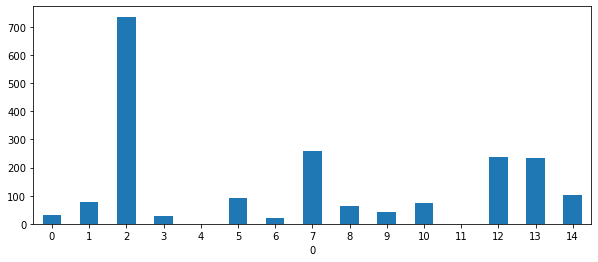

In [23]:
pd.DataFrame(train_clusters).groupby(0).size().plot(kind='bar', rot=0, figsize=(10, 4));

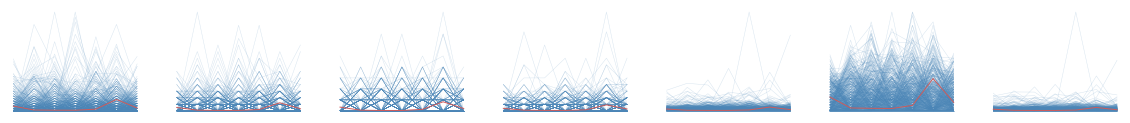

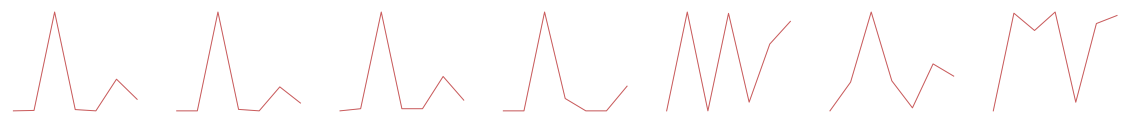

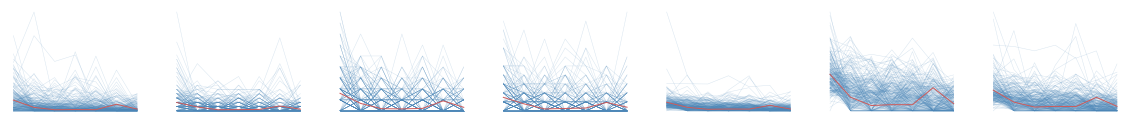

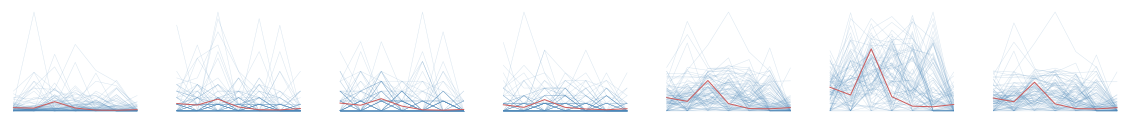

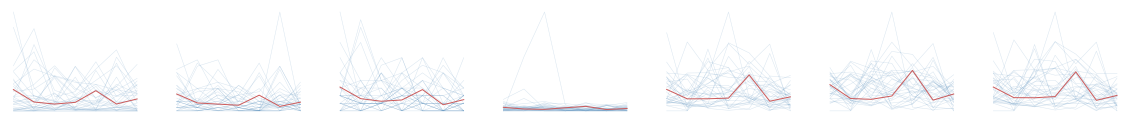

In [28]:
for i in np.random.choice(dtw_kmeans.n_clusters, 5):
    plot_time_series_all_features(x_train_sample[train_clusters == i], dtw_kmeans.cluster_centers_[i], figsize=(20, 2), alpha=0.2)

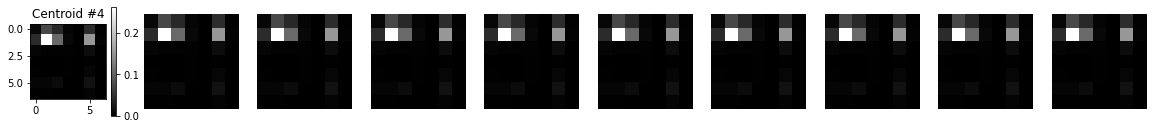

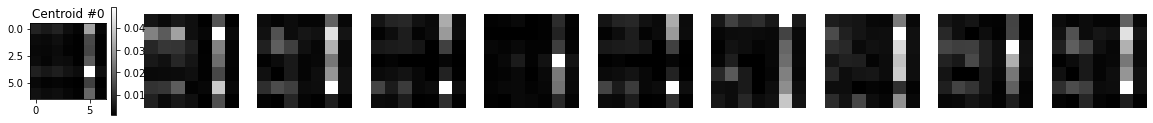

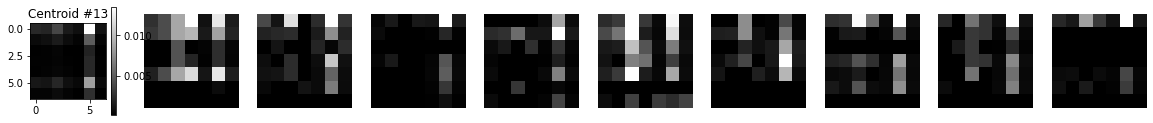

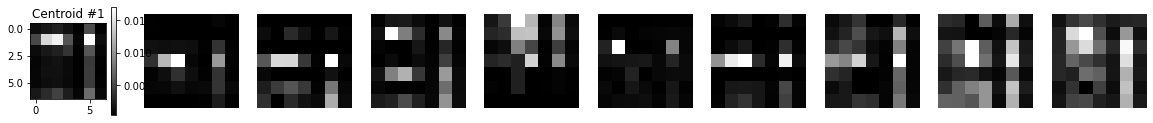

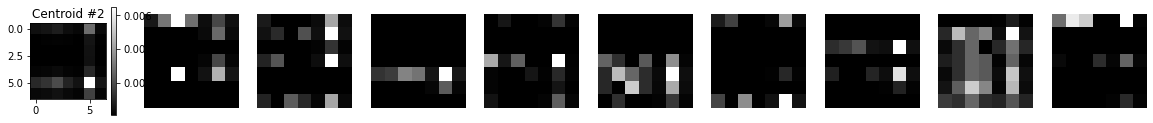

In [25]:
for i in np.random.choice(dtw_kmeans.n_clusters, 5):
    n_ts = 9
    fig, ax = plt.subplots(1, n_ts + 1, figsize=(20, 2))
    ax[0].set_title(f'Centroid #{i}')
    centroid_img = ax[0].imshow(dtw_kmeans.cluster_centers_[i], cmap='gray')
    x_in_cluster = x_train_sample[train_clusters == i]
    for i, s in enumerate(x_in_cluster[np.random.choice(len(x_in_cluster), n_ts)]):
        ax[i + 1].imshow(s, cmap='gray')
        ax[i + 1].set_axis_off()
    plt.colorbar(centroid_img, ax=ax[0])
    plt.show()

## Define the autoencoder

In [ ]:
latent_shape = 4
learning_rate = 0.01
sequence_length = 7

## --> Uncomment this part to turn it to a variational autoencoder
# prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_shape))

# kl_div_regularizer = tfpl.KLDivergenceRegularizer(
#     prior,
#     use_exact_kl=True)

activation = tfkl.LeakyReLU()

encoder = tfk.Sequential([
    tfkl.Input((sequence_length, 7)),
    tfkl.Conv1D(32, 3, strides=2, padding='SAME', activation=activation),
    tfkl.BatchNormalization(),
    tfkl.Conv1D(64, 3, strides=2, padding='SAME', activation=activation),
    tfkl.BatchNormalization(),
    tfkl.Flatten(),
    tfkl.Dense(latent_shape)
## --> Uncomment this part to turn it to a variational autoencoder
#     tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_shape)),
#     tfpl.MultivariateNormalTriL(
#         latent_shape,
#         activity_regularizer=kl_div_regularizer)
], name='encoder')

decoder = tfk.Sequential([
    tfkl.Dense(256, activation='relu', input_shape=(latent_shape,)),
    tfkl.Reshape((2, 1, 128)),
    tfkl.BatchNormalization(),
    tfkl.Conv2DTranspose(32, (3, 1), strides=(2, 1), activation=activation, padding='SAME'),
    tfkl.BatchNormalization(),
    tfkl.Conv2DTranspose(7, (3, 1), strides=(2, 1), activation=activation, padding='SAME'),
    tfkl.Cropping2D(((0, 1), (0, 0))),
    tfkl.Flatten(),
    tfpl.IndependentBernoulli((sequence_length, 7))
], name='decoder')

print(encoder.summary())
print(decoder.summary())

def rel_mae(y_true, y_pred, epsilon=10e-5):
    return tf.reduce_mean(tf.where(y_true < epsilon, 0.0, tf.abs(y_true - y_pred) / tf.abs(y_true)))

def nll(x, dist):
    return - tf.reduce_mean(dist.log_prob(x))

autoencoder = tfk.Model(encoder.inputs, decoder(encoder.outputs))
autoencoder.compile(optimizer=tfk.optimizers.Adam(learning_rate=learning_rate), loss=nll, metrics=[rel_mae])

## Train and export the model

In [ ]:
%%time
rl_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    verbose=1
)

history = autoencoder.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=[rl_scheduler],
    verbose=1)

In [ ]:
start_after_drop = 1

plt.title('Negative log-likelihood')
plt.plot(history.history['loss'][start_after_drop:], label='train')
plt.plot(history.history['val_loss'][start_after_drop:], label='valid')
plt.legend()
plt.show()
plt.title('Mean absolute error')
plt.plot(history.history['rel_mae'][start_after_drop:], label='train')
plt.plot(history.history['val_rel_mae'][start_after_drop:], label='valid')
plt.legend()
plt.show()

In [ ]:
idxs = np.random.choice(len(weekly_ts), 10)
samples = weekly_ts[idxs]
samples_rec = autoencoder(samples).mean().numpy()

_, ax = plt.subplots(2, len(idxs), figsize=(30, 4))
for i, idx in enumerate(idxs):
    ax[0][i].imshow(samples[i], cmap='gray')
    ax[1][i].imshow(samples_rec[i], cmap='gray')
plt.show()

In [ ]:
autoencoder.save('../models/user_logs_autoencoder_v1')
autoencoder.save_weights('../models/user_logs_autoencoder_v1_weights')

In [ ]:
encoder.save('../models/user_logs_encoder_v1')
encoder.save_weights('../models/user_logs_encoder_v1_weights')

## Cluster the latent space with a gaussian mixture model
Here it is still feasible to do that with sklearn. For large amount of data use tensorflow probability to define and train a custom mixture model.

In [ ]:
latent_values = encoder.predict(train_ds)

In [ ]:
%%time
mixture = GaussianMixture(n_components=100)
mixture.fit(latent_values)

In [ ]:
%%time
tsne = TSNE()
planar_values = tsne.fit_transform(np.vstack([latent_values[np.random.choice(len(latent_values), 2000)], mixture.means_]))

In [ ]:
plt.scatter(*planar_values.T, s=1, color='steelblue')
plt.scatter(*planar_values[-len(mixture.means_):].T, color='indianred', s=15)
plt.show()

In [ ]:
train_components = mixture.predict(latent_values)

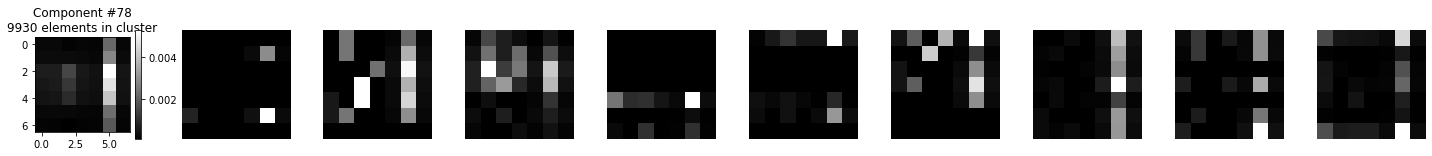

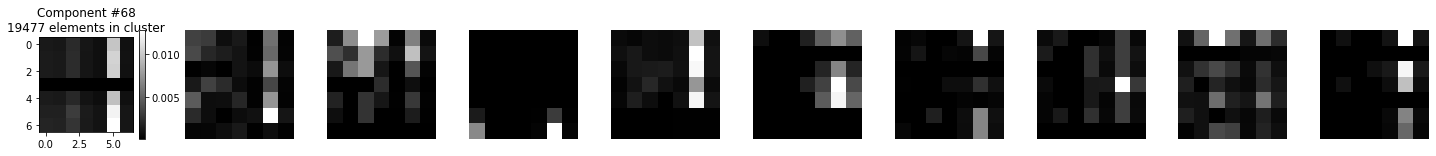

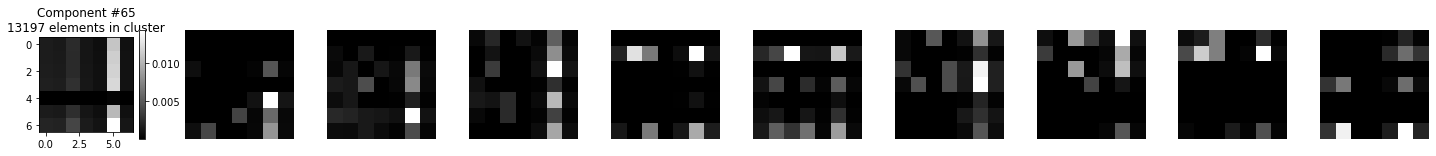

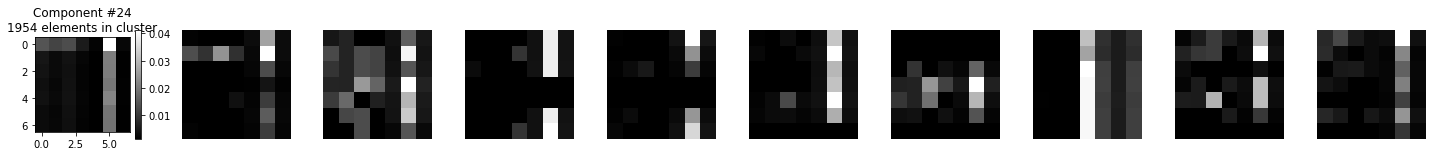

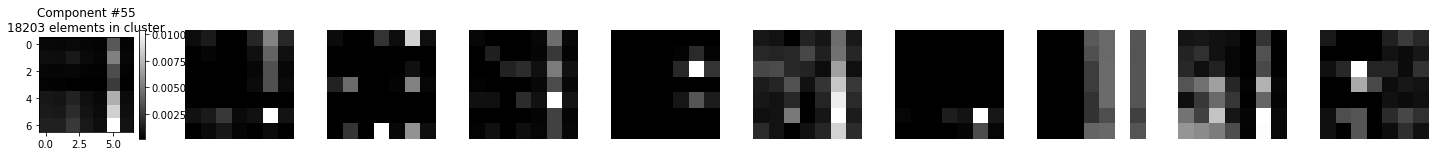

In [43]:
for i in np.random.choice(mixture.n_components, 5):
    n_ts = 9
    fig, ax = plt.subplots(1, n_ts + 1, figsize=(25, 2))
    x_in_cluster = x_train[train_components == i]
    ax[0].set_title(f'Component #{i}\n{len(x_in_cluster)} elements in cluster')
    component_center_img = ax[0].imshow(decoder(np.expand_dims(mixture.means_[i], axis=0)).mean()[0], cmap='gray')#, vmin=0, vmax=1)
    for i, s in enumerate(x_in_cluster[np.random.choice(len(x_in_cluster), n_ts)]):
        ax[i + 1].imshow(s, cmap='gray')#, vmin=0, vmax=1)
        ax[i + 1].set_axis_off()
    plt.colorbar(component_center_img, ax=ax[0])
    plt.show()

## Visualize the clusters distribution and some of the results

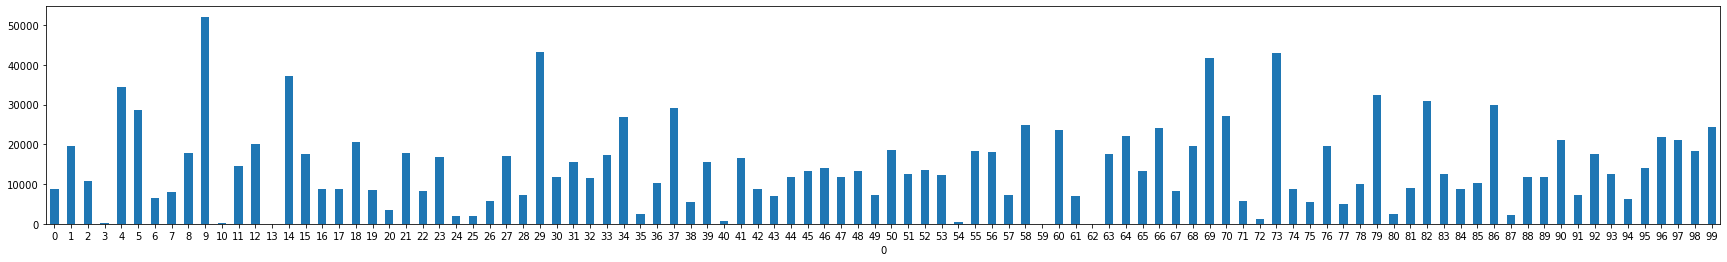

In [40]:
pd.DataFrame(train_components).groupby(0).size().plot(kind='bar', rot=0, figsize=(30, 4));

## Map all user logs to latent features and classes